In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
import re

fon_re = re.compile('[0-9X]{2,4}-[0-9Xx]{2,4}-[0-9Xx]{2,4}')

deny_re = re.compile("무료거부|무료수신거부")

In [29]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    etc = []
    condition = False
    
    if sentence[:4] == '(광고)':
        etc.append(1)
        sentence = sentence[4:]
    else:
        etc.append(0)
    
    # 무료거부 메시지 있는가
    etc.append(1 if len(deny_re.findall(sentence)) > 0 else 0)
    # 전화번호 형식이 있는가
    etc.append(1 if len(fon_re.findall(sentence)) > 0 else 0)
    
    prev_pos = ''
    count_ec, count_m, count_n, count_vv = 0, 0, 0, 0
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'M':
            nouns.append(word[0])
            count_m += 1
        if word[1][:1] == 'N':
            count_n += 1
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            elif word[0] == '시' and prev_pos[:1] == 'N':  # 넣으나 마나.. 왜 그렇지?
                condition = True
            else:
                nouns.append(word[0])
        # 도 : 여도, 라도
        # 면 : 라면, 면
        elif word[1] == 'EC':
            count_ec += 1
            if word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록'):
                condition = True
        elif word[1][:1] == 'V':
            count_vv += 1
            nouns.append(word[0])
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # nouns가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            nouns.append(word[0])
            ret.append([word[0], condition, nouns])
            nouns = []
            condition = False
        prev_pos = word[1]
    if len(nouns) > 0:
        nouns.append(word[0])
        ret.append([word[0], condition, nouns])
    
    etc += [count_ec, count_m, count_n, count_vv]
    
    # 가장 많은 단어를 가진 조건절만 남기고 나머지는 일반문장으로 원복
    max_len, selected = 0, -1
    for idx, item in enumerate(ret):
        if item[1] == True and len(item[2]) > max_len:
            selected, max_len = idx, len(item[2])
        ret[idx][1] = False
    if selected >= 0:
        ret[selected][1] = True
    return ret, etc

In [30]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited, etc = parse_sentence(item.text)
    # 일반 피쳐를 여기에서 etc에 넣는다
    etc.append(len(item.text))
    splited.append(etc)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-25 19:05:11.583479 0
2019-12-25 19:06:03.567400 100000
2019-12-25 19:06:57.326566 200000


In [31]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [38]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [39]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
general_df = general_df[general_df.index.map(len) > 1]

# 출현빈도가 일정 개수 이상되는 키워드만 표시해보면
display(conditioned_df[conditioned_df > 50])  # 조건절이 있는 문장에서 출현 빈도
display(general_df[general_df > 500])

첫날        98
아니      2603
누군가      250
행복     13275
내내       144
       ...  
기울일       64
자채       299
면책        63
채팅       479
원거        52
Length: 2584, dtype: int64

행성       659
팀장     33529
입니다    81742
행복     96186
주말     47470
       ...  
지급금      803
전폭       560
사대      1170
도최      1272
승인서      660
Length: 1416, dtype: int64

In [40]:
# size of feature vector : 아래 두 숫자를 합한 것만큼이 피쳐개수가 됨 \ 위의 출현개수 기반으로 판단해볼것
# 참고 : 400/400 에서 늘려서.. 700/500 800/400 600/600 이렇게 해봐도.. 아래 케이스에서 못맞히는 개수가 12~14개 꾸준함... ㅎㅎ
# 400/400 일 때는 15개 틀림.. 좀 늘리면 12개 까지는 좋아질 수 있음.. 합이 1200을 넘으면 너무 느려져서 사용불가 (이 mac기준)
CONDITION_WORD_FTR_SIZE = 300  
GENERAL_WORD_FTR_SIZE = 400

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)

In [41]:
train_conditioned = []
train_general = []
train_etc = []

In [42]:
original_idx = []
for normal in normals:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in normal[:-2]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_etc.append(normal[-2])
    original_idx.append(normal[-1])

In [43]:
for smishing in smishings:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in smishing[:-2]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_etc.append(smishing[-2])
    original_idx.append(smishing[-1])

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_conditioned = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_general = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

tidf_conditioned = vectorizer_conditioned.fit_transform(train_conditioned)
tidf_general = vectorizer_general.fit_transform(train_general)

In [45]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned.toarray())
tidf_general = np.array(tidf_general.toarray())
ftr_etc = np.array(train_etc)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [46]:
TRAIN_RATIO, VALID_RATIO = 0.6, 0.8
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < TRAIN_RATIO]
tidf_cond_valid = tidf_conditioned[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_cond_test = tidf_conditioned[split >= VALID_RATIO]

tidf_gen_train = tidf_general[split < TRAIN_RATIO]
tidf_gen_valid = tidf_general[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_gen_test = tidf_general[split >= VALID_RATIO]

ftr_etc_train = ftr_etc[split < TRAIN_RATIO]
ftr_etc_valid = ftr_etc[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
ftr_etc_test = ftr_etc[split >= VALID_RATIO]

tidf_label_train = tidf_label[split < TRAIN_RATIO]
tidf_label_valid = tidf_label[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_label_test = tidf_label[split >= VALID_RATIO]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533, 300), (59281, 300))

In [47]:
tidf_gen_train.shape, tidf_gen_valid.shape #, tidf_gen_test.shape

((177533, 400), (59281, 400))

In [72]:
INPUT1, INPUT2, DENSE1, DENSE4 = 16, 32, 32, 24

n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
n_etc = ftr_etc.shape[1]
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')
etc_input = keras.layers.Input(shape=(n_etc,), name='Etc')

#cond_vec_mlp = keras.layers.Embedding(n_cond, num_predictive_factors, )(cond_input)
#cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
#cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

#gen_vec_mlp = keras.layers.Embedding(n_gen, num_predictive_factors)(gen_input)
#gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
#gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

enc_input1 = keras.layers.Dense(INPUT1, name='AutoEncoder-1')(cond_input)
dropout_input1 = keras.layers.Dropout(0.1, name='enc_input1')(enc_input1)
enc_input2 = keras.layers.Dense(INPUT2, name='AutoEncoder-2')(gen_input)
dropout_input2 = keras.layers.Dropout(0.1, name='enc_input2')(enc_input2)

concat_mlp = keras.layers.merge.concatenate([dropout_input1, dropout_input2, etc_input])
concat_dropout_mlp = keras.layers.Dropout(0.2)(concat_mlp)

dense = keras.layers.Dense(DENSE1, kernel_regularizer=keras.regularizers.l2(0.002), name='FullyConnected-1', activation='relu')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.4, name='Dropout-1')(dense)

# dense_2 = keras.layers.Dense(128, name='FullyConnected-2')(dropout_1)
# dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

# dense_3 = keras.layers.Dense(512, name='FullyConnected-3')(dropout_2)
# dropout_3 = keras.layers.Dropout(0.2, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(DENSE4, kernel_regularizer=keras.regularizers.l2(0.002), name='FullyConnected-4', activation='relu')(dropout_1)

pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input, etc_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
#model.compile(optimizer=keras.optimizers.Adamax(lr=1e-3), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])

/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [73]:
tidf_label_valid.shape, sum(tidf_label_valid)

((59281,), 3724)

In [74]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, ftr_etc_train, tidf_label_train, normal_size=160, smishing_size=160):
        self.tidf_cond_train_normal = tidf_cond_train[tidf_label_train == 0]
        self.tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = tidf_cond_train[tidf_label_train == 1]
        self.tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
        self.ftr_etc_train_normal = ftr_etc_train[tidf_label_train == 0]
        self.ftr_etc_train_smishing = ftr_etc_train[tidf_label_train == 1]
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size)))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        normal_etc_sample = self.ftr_etc_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        smishing_etc_sample = self.ftr_etc_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_etc_train = np.concatenate([normal_etc_sample, smishing_etc_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train, sample_etc_train], sample_label_train

    def on_epoch_end(self):
        pass

In [75]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, ftr_etc_train, tidf_label_train, 160, 160)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, ftr_etc_valid, tidf_label_valid, 2000, 2000)

history = model.fit_generator(generator=train_gen,
                             epochs = 80,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 520
num_batch: 14
Epoch 1/80
520/520 [==============================] - 12s 22ms/step - loss: 2.3525 - binary_crossentropy: 2.2366 - acc: 0.5228 - val_loss: 1.0440 - val_binary_crossentropy: 0.9414 - val_acc: 0.5010
Epoch 2/80
520/520 [==============================] - 6s 11ms/step - loss: 1.0674 - binary_crossentropy: 0.9721 - acc: 0.6524 - val_loss: 0.4613 - val_binary_crossentropy: 0.3701 - val_acc: 0.8736
Epoch 3/80
520/520 [==============================] - 3s 6ms/step - loss: 0.4888 - binary_crossentropy: 0.3980 - acc: 0.8796 - val_loss: 0.1381 - val_binary_crossentropy: 0.0479 - val_acc: 0.9931
Epoch 4/80
520/520 [==============================] - 9s 18ms/step - loss: 0.2526 - binary_crossentropy: 0.1641 - acc: 0.9517 - val_loss: 0.1117 - val_binary_crossentropy: 0.0254 - val_acc: 0.9964
Epoch 5/80
520/520 [==============================] - 8s 15ms/step - loss: 0.1785 - binary_crossentropy: 0.0949 - acc: 0.9725 - val_loss: 0.1114 - val_binary_crossentropy: 0.0305 - va

520/520 [==============================] - 3s 6ms/step - loss: 0.0173 - binary_crossentropy: 0.0063 - acc: 0.9986 - val_loss: 0.0216 - val_binary_crossentropy: 0.0107 - val_acc: 0.9977
Epoch 43/80
520/520 [==============================] - 3s 6ms/step - loss: 0.0173 - binary_crossentropy: 0.0066 - acc: 0.9985 - val_loss: 0.0201 - val_binary_crossentropy: 0.0096 - val_acc: 0.9980
Epoch 44/80
520/520 [==============================] - 3s 6ms/step - loss: 0.0157 - binary_crossentropy: 0.0054 - acc: 0.9987 - val_loss: 0.0192 - val_binary_crossentropy: 0.0091 - val_acc: 0.9978
Epoch 45/80
520/520 [==============================] - 3s 6ms/step - loss: 0.0157 - binary_crossentropy: 0.0058 - acc: 0.9986 - val_loss: 0.0206 - val_binary_crossentropy: 0.0108 - val_acc: 0.9976
Epoch 46/80
520/520 [==============================] - 3s 6ms/step - loss: 0.0154 - binary_crossentropy: 0.0058 - acc: 0.9986 - val_loss: 0.0194 - val_binary_crossentropy: 0.0098 - val_acc: 0.9981
Epoch 47/80
520/520 [======

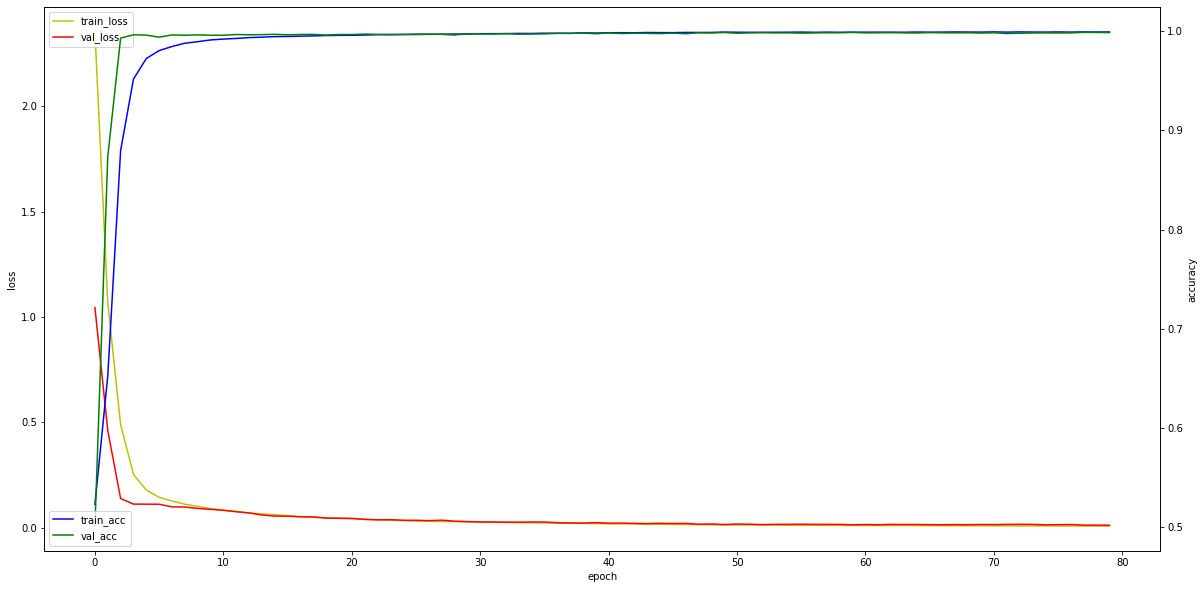

In [76]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

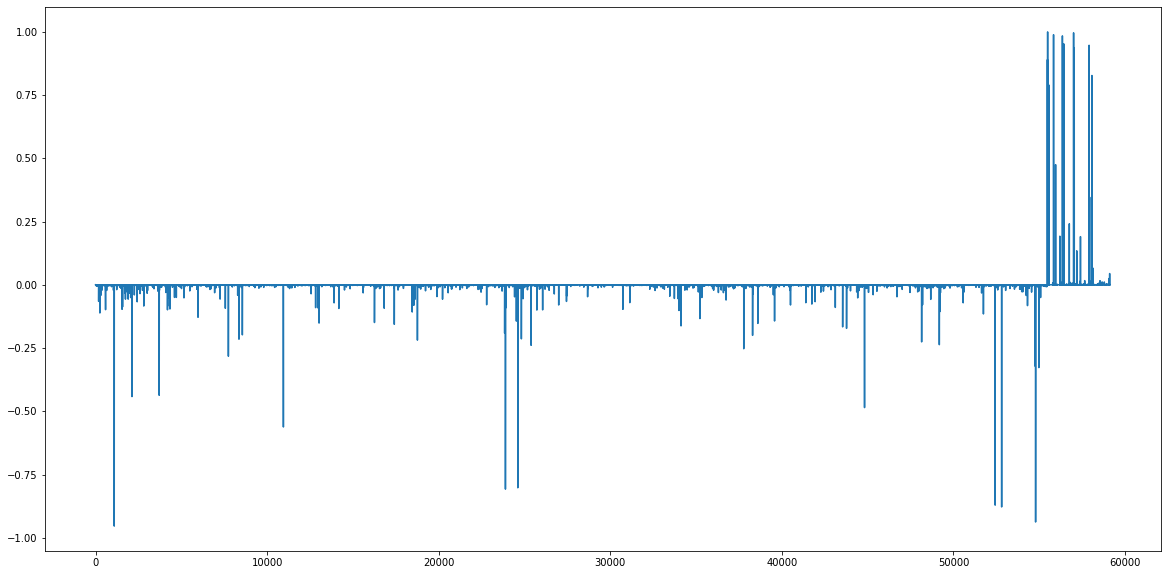

In [77]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, ftr_etc_test], batch_size=160)
gap = tidf_label_test - pred_test.reshape([-1,])

plt.figure(figsize=(20,10))
plt.plot(gap)

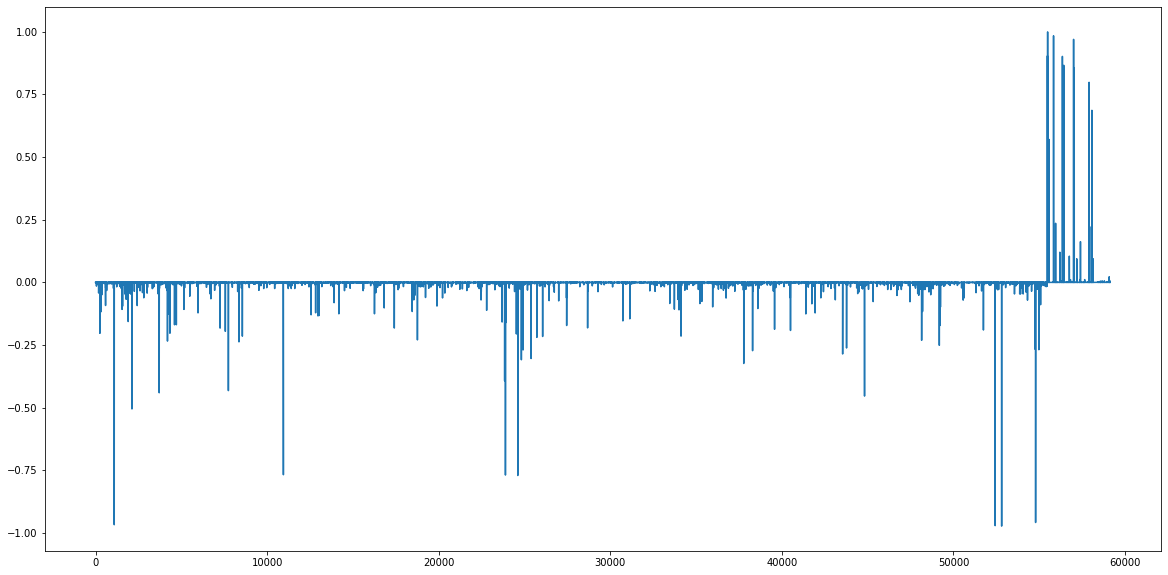

In [71]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, ftr_etc_test], batch_size=160)
gap = tidf_label_test - pred_test.reshape([-1,])

plt.figure(figsize=(20,10))
plt.plot(gap)

auc : 0.9999750965231377


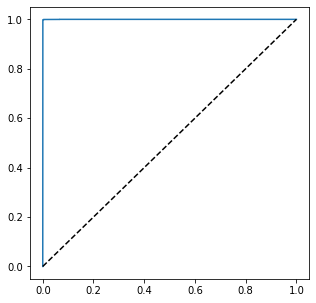

In [78]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [25]:
df[df['id'].isin(np.array(original_idx)[split >= 0.8][gap > 0.5])].text.map(print)

(광고)XXX신년특별빠르게천만원월39000원통화1번(무료거부XXX-XXX-XXX)
(광고) 정관장에서 미리 설 준비하시고 특별한 혜택 받으세요!! 예약기간 : 13(화)  19(월) 행사내용 :- 밝을윤세트 은혜은세트 원앙세트 3종 구매 예약시 5% 포인트 추가 적립- 예약방법은 매장으로 문의하여 주세요. 20만원 XXX입 시 1만원 할인- 기간:11128까지적용카드: 현대이마트카드.삼성카드.XXX국민카드.현대카드.XXX카드 결재 시 적용됨. 예약문의 : 정관장 서울 이마트가양점 전화:XX-XXX-XXX 무료수신거부 : XXX-XXX-XXX(광고)정관장 사전예XXX
SK텔레콤 2017년 1월 XXX이번달 납부하실 금액은 20650원 입니다.XXX 고객번호 : 010-16-3505 자동납부접수번호 : XXX-XXX-XXX 납기일 : 2017.1.23. 말일이 지나면 2%의 가산금이 두 달 후에 청구됩니다.이번달 금액 상세내역 단말기할부금 단말기할부금() - 단말기할부원금 : 20450원 - 단말기할부이자 : 200원 이번달금액 : 20650원 단말기 할부 대수 : 1대 단말기 총 할부금 : 743616원(총 할부개월 : 36개월) 단말기할부금 잔액 : 40056원(잔여개월 : 2개월) 자동납부은행 : XXX 계좌번호 : 고객요청에 의한 미기재 인출예정일 : 2017.1.23. ()표시 항목은 당사에서 청구 대행하는 타사 요금입니다. 표시 항목은 부가가치세 제외 대상입니다. 고객님께서 요청하신 번호로 문자XXX를 보내드리오니 이동전화번호가 변경될 경우 SK텔레콤 고객센터로 연락바랍니다. 1월 5일 기준으로 작성된 금액입니다.SK텔레콤 문자 XXX
피플라이프재무설계XXX팀장입니다 이번에찾아뵙는 금융서비스라고해서은행 예.적금CMAMMF 등관련하여 1:1 재무설계를직접 찾아뵙고 무료상담을 도와드리고있습니다Ex) 현재-시중은행 1.25% 금리이용하시는분들같은 경우상담후-최저보증2.9% 비과세상품 이용하실수있는 방법을 기본베이스로안내를 도와드리고XXX고객님께서 가입되어있는

440       None
938       None
5711      None
6221      None
33905     None
76671     None
137858    None
138214    None
149795    None
193787    None
195865    None
196896    None
223491    None
252122    None
256306    None
Name: text, dtype: object

In [86]:
# 특정 키워드가 feature dic에 포함되려면(feature가 되려면) 어느정도의 dic크기가 지정되어야 하나
keyword = '취업'
CONDITION_WORD_FTR_SIZE = 3500
GENERAL_WORD_FTR_SIZE = 3500

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)
keyword in general_dic, keyword in conditioned_dic

(True, True)

In [139]:
keyword = '전시'
keyword in general_dic, keyword in conditioned_dic

(True, True)

In [ ]:
# 제출 준비

In [79]:
submit_df = pd.read_csv('./data/public_test.csv')

In [80]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited, etc = parse_sentence(item.text)
    # 일반 피쳐를 여기에서 etc에 넣는다
    etc.append(len(item.text))
    splited.append(etc)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2019-12-25 21:17:16.344539 0


In [81]:
test_conditioned = []
test_general = []
test_etc = []

original_idx = []
for unknown in unknowns:
    conditioned = []
    general = []
    for item in unknown[:-2]:
        if item[1] == True:
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    test_conditioned.append(list(conditioned))
    test_general.append(list(general))
    test_etc.append(unknown[-2])
    original_idx.append(unknown[-1])

In [82]:
tidf_conditioned = vectorizer_conditioned.transform(test_conditioned).toarray()
tidf_general = vectorizer_general.transform(test_general).toarray()
ftr_etc = np.array(test_etc)

In [83]:
pred_y = model.predict(x=[tidf_conditioned, tidf_general, ftr_etc], verbose=1)

1626/1626 [==============================] - 0s 100us/step


In [84]:
pred_y[pred_y > 1.0] = 1.0

In [85]:
submit_df['smishing'] = np.abs(pred_y)

In [86]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20191225_2.csv', index=False)